# LaLiga Data Analysis


The first code chunk is used to import the dependancies and the data needed to perform the analysis. To check that we have the right data taken from the github repository, we examine the top and the bottom of the newly created data frame.

In [23]:
import sqlite3
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

conn = sqlite3.connect('../laliga.sqlite')
df = pd.read_sql_query("SELECT * FROM Matches", conn)
df = df.dropna(axis = 'index' , how = 'any', subset = 'score')
display(df.head())
display(df.tail())

# Close the connection when done
conn.close()

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2


,season,division,matchday,date,time,home_team,away_team,score
48345,2021-2022,2,3,8/28/21,10:00 PM,Ponferradina,Girona,2:1
48346,2021-2022,2,3,8/29/21,5:00 PM,SD Amorebieta,UD Almería,2:1
48347,2021-2022,2,3,8/29/21,7:30 PM,CD Lugo,Real Valladolid,0:2
48348,2021-2022,2,3,8/29/21,7:30 PM,Real Sociedad B,CF Fuenlabrada,0:0
48349,2021-2022,2,3,8/29/21,10:00 PM,Burgos CF,SD Eibar,0:1


*1. Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or
there’s a tie) of all matches in the data. Write in the plot the percentage of
each category*

We first separate the home score and the away score in two new columns. Using this, we can delete the matches taht have not been played yet. Then, we define wheter it is a home or away win and compute hte distribution of results. Finally we plot the pie chart showing the result distribution of all the data.

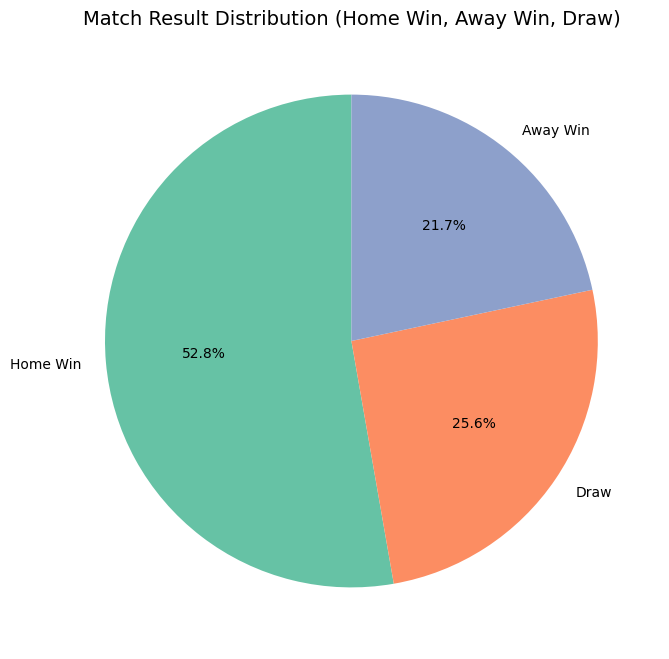

In [24]:
df[['home_score', 'away_score']] = df['score'].str.split(':', expand=True)
df['home_score'] = pd.to_numeric(df['home_score'])
df['away_score'] = pd.to_numeric(df['away_score'])

# There are matches in the data that haven't been played. We must avoid them.
df = df[(~df['home_score'].isnull()) | (~df['away_score'].isnull())]

df['result'] = df.apply(lambda row: 'Home Win' if row['home_score'] > row['away_score']
                                        else 'Away Win' if row['home_score'] < row['away_score']
                                        else 'Draw', axis=1)

result_counts = df['result'].value_counts()

# Plot
plt.figure(figsize=(8, 8))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66c2a5','#fc8d62','#8da0cb'])
plt.title('Match Result Distribution (Home Win, Away Win, Draw)', fontsize=14)
plt.show()


*2. What are the top ten scoring teams of all time? What are the ten teams
that concede the most? Make two bar plot charts showing each of them.
Consider only matches played in 1st division.
What have been the biggest wins? Of course, when we say biggest we mean
those with the highest goal difference. Show the top ten of them in a table.*

*Note: In the second part of the delivery we have found that some teams appear with different names because they had been renamed. In order to get the correct results for this exercise we should consider it. However, since in here it only affects `Atlético Madrid` and to notice it needs a bit of football knowledge, we have considered that the database is correct.*

In order to compute the top ten scoring teams, we have to sum goals scored as a home team and as a visitor.

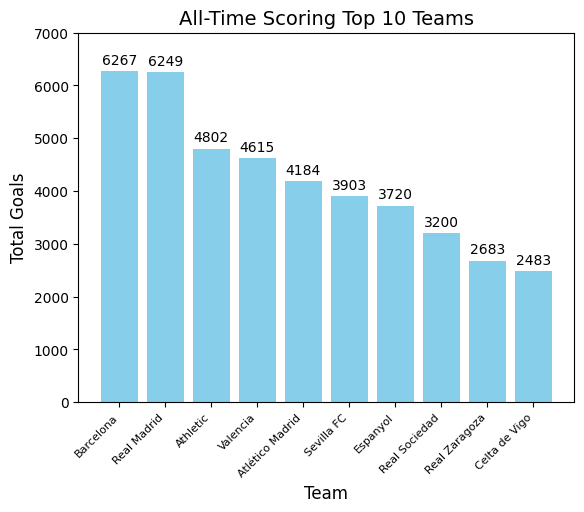

In [25]:
df_1st_div = df.loc[df['division'] == 1,:]

home_goals = df_1st_div.groupby('home_team')['home_score'].sum().reset_index()
home_goals.columns = ['team', 'home_goals']

away_goals = df_1st_div.groupby('away_team')['away_score'].sum().reset_index()
away_goals.columns = ['team', 'away_goals']

all_time = pd.merge(home_goals, away_goals, on='team', how='outer').fillna(0)

all_time['total_goals'] = all_time['home_goals'] + all_time['away_goals']

# If we sort them, the top 10 will be the first 10 teams
all_time = all_time.sort_values(by='total_goals', ascending=False)

# Plot
top_10 = all_time.head(10)
bars = plt.bar(top_10['team'], top_10['total_goals'], color='skyblue')
plt.xlabel('Team', fontsize=12)
plt.ylabel('Total Goals', fontsize=12)
plt.title('All-Time Scoring Top 10 Teams', fontsize=14)
plt.bar_label(bars, padding=3, fontsize=10)
plt.gca().set_xticks(range(len(top_10['team'])))
plt.gca().set_xticklabels(top_10['team'], rotation=45, ha='right', fontsize=8)
plt.ylim(0,7000)
plt.show()

We do the same with the conceded goals.

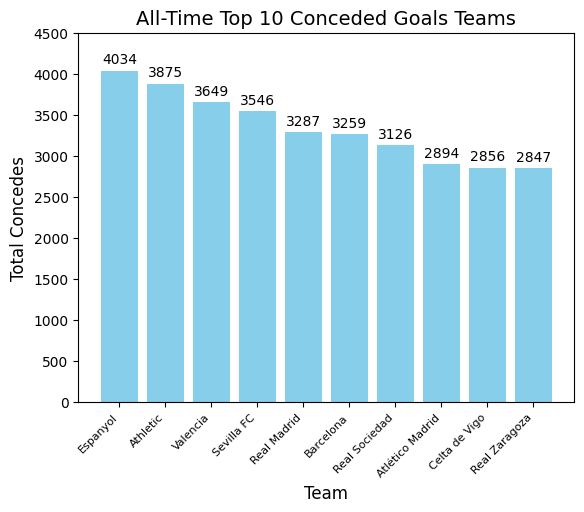

In [26]:
home_conceding = df_1st_div.groupby('home_team')['away_score'].sum().reset_index()
home_conceding.columns = ['team', 'concedes_when_home']

away_conceding = df_1st_div.groupby('away_team')['home_score'].sum().reset_index()
away_conceding.columns = ['team', 'concedes_when_away']

all_time_concedes = pd.merge(home_conceding, away_conceding, on='team', how='outer').fillna(0)

all_time_concedes['total_concedes'] = all_time_concedes['concedes_when_home'] + all_time_concedes['concedes_when_away']
# If we sort them, the top 10 will be the first 10 teams
all_time_concedes = all_time_concedes.sort_values(by='total_concedes', ascending=False)

# Plot
top_10_concedes = all_time_concedes.head(10)
bars = plt.bar(top_10_concedes['team'], top_10_concedes['total_concedes'], color='skyblue')
plt.xlabel('Team', fontsize=12)
plt.ylabel('Total Concedes', fontsize=12)
plt.title('All-Time Top 10 Conceded Goals Teams', fontsize=14)
plt.bar_label(bars, padding=3, fontsize=10)
plt.gca().set_xticks(range(len(top_10_concedes['team'])))
plt.gca().set_xticklabels(top_10_concedes['team'], rotation=45, ha='right', fontsize=8)
plt.ylim(0,4500)
plt.show()

To find the biggest wins in first division, we compute the goal difference of each match.

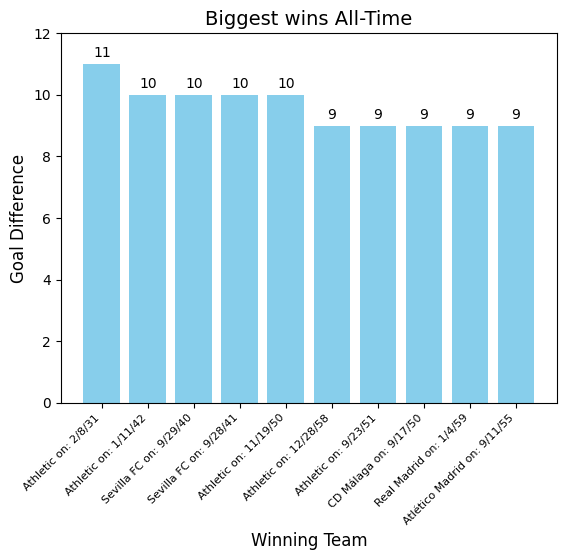

In [27]:
df_1st_div = df_1st_div.assign(goal_diff=abs(df_1st_div['home_score'] - df_1st_div['away_score']))

# Sorting the data allows us to find the top 10 biggest wins at the top
top10_wins = df_1st_div.sort_values(by='goal_diff', ascending=False).head(10)
top10_wins.loc[:, 'Winning Team'] = top10_wins.apply(
    lambda x: f"{x['home_team']} on: {x['date']}" if x['result'] == 'Home Win'
    else f"{x['away_team']} on: {x['date']}", axis=1)

# Plot
bars = plt.bar(top10_wins['Winning Team'], top10_wins['goal_diff'], color='skyblue')
plt.xlabel('Winning Team', fontsize=12)
plt.ylabel('Goal Difference', fontsize=12)
plt.title('Biggest wins All-Time', fontsize=14)
plt.bar_label(bars, padding=3, fontsize=10)
plt.gca().set_xticks(range(len(top10_wins['Winning Team'])))
plt.gca().set_xticklabels(top10_wins['Winning Team'], rotation=45, ha='right', fontsize=8)
plt.ylim(0,12)
plt.show()


*3. There has been a lot of discussion about how LaLiga’s television rights have
changed game schedules in the last years. Make a bar plot chart showing
the number of matches played each weekday, and make also a histogram
of match time. Compare this two graphics between seasons 2000-2001 and
2020-2021.*

Even though we only use the last 20 seasons, we have to rule out all those matches that don't have the match time, since they are automatically set to sunday. We transform the date to the corresponding day of the week, and we also save the hour of the match using the 24 hours format. Then, we extract the hour of it to do the histogram and delete the matches with no matchtime. This next cell has the histogram of the number of matches played each weekday.

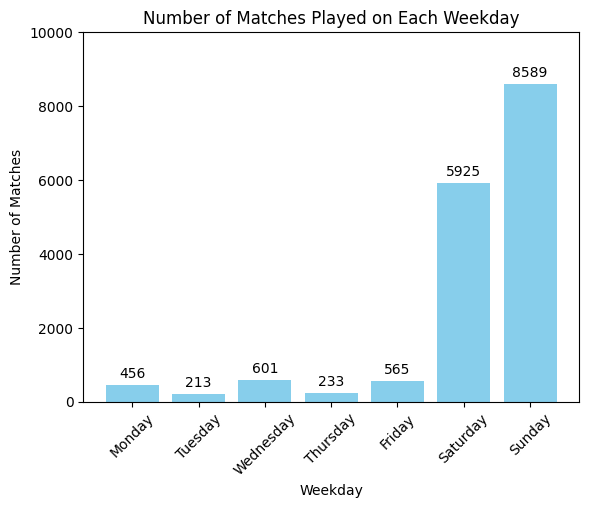

In [28]:
tel_rights = df.loc[(df['season'] >= '2000-2001') & (df['season'] <= '2020-2021')].copy()

tel_rights['date'] = pd.to_datetime(tel_rights['date'], format='%m/%d/%y')

# This gets the day of the week from the date
tel_rights['weekday'] = tel_rights['date'].dt.day_name()

tel_rights['time_absolute'] = pd.to_datetime(tel_rights['time'], format='%I:%M %p')
tel_rights['hour'] = tel_rights['time_absolute'].dt.hour

# Delete the matches that dont have a specific time assigned
tel_rights = tel_rights[~tel_rights['time_absolute'].isna()]

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_counts = tel_rights['weekday'].value_counts().reindex(weekday_order, fill_value=0)

# Plot
bars = plt.bar(weekday_order, weekday_counts, color='skyblue')
plt.title("Number of Matches Played on Each Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Matches")
plt.bar_label(bars, padding=3, fontsize=10)
plt.xticks(rotation=45)
plt.ylim(0,10000)
plt.show()

Then, we plot the histogram with the match time. Since we have only extracted the hour, we can define a bin for each hour to see the distribution more easily.

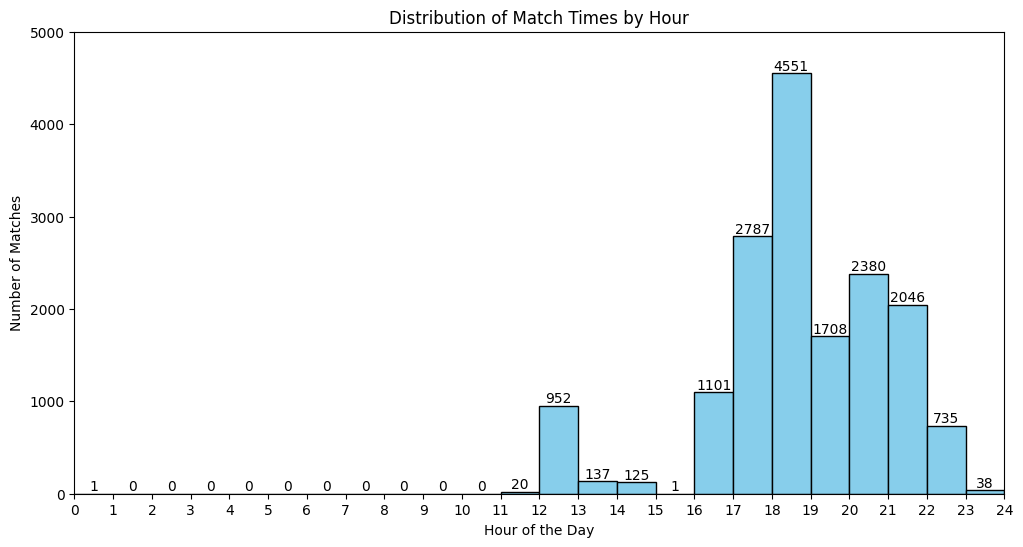

In [29]:
# Plot
plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(tel_rights['hour'], bins=24, range=(0, 24), color='skyblue', edgecolor='black')
plt.title("Distribution of Match Times by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Matches")
plt.xticks(range(0, 25))
plt.xlim(0,24)
plt.ylim(0,5000)

for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count,
             f'{int(count)}', ha='center', va='bottom')

plt.show()

*4. Build a cross results table for season 2020-2021 (1st division). Figure 1 is an
example taken from Wikipedia. Try to make it the most similar to this one:
use team abbreviations as column names and paint the background of each
cell according to result (green in case local team wins and red in case visitor
team wins). Also, could you model the intensity of this background color
with the goal difference from the match?*

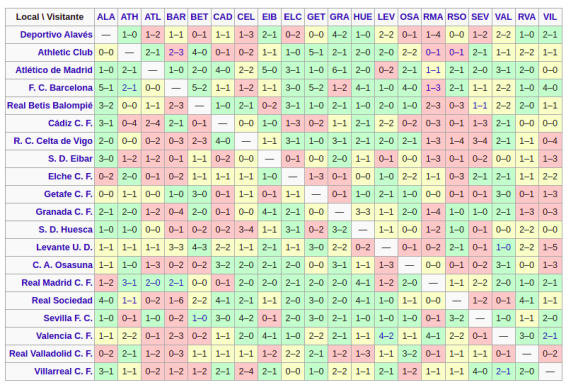

*Write a function that, given the season and division, plots the cross results table. Function prototype should be like plot_cross_results_table(season, division) and return the plot object.*

We define two different functions: the first one modifies the background color as a function fo the goal difference form each match. The second one plots the cross results table in a similar way to the previous one.

In [30]:
def score_highlighter(x):
    # We have put black squares in the diagonal because we thought that it makes it more visual
    if x == "-":
        return "background-color: #000000; color: black; font-weight: bold;"

    try:
        home_score, away_score = map(int, x.split(":"))
    except ValueError:
        return ""

    goal_diff = home_score - away_score

    cmap = mcolors.LinearSegmentedColormap.from_list("goal_diff_cmap", ["#FF0000", "#FFFFFF", "#006400"])
    norm = mcolors.Normalize(vmin=-5, vmax=5)  # The maximum goal difference is 5

    color = mcolors.rgb2hex(cmap(norm(goal_diff)))

    return f"background-color: {color}; color: black; font-weight: bold;"


def plot_cross_results_table(df,season,division,rename=None):

  df_subset = df.loc[(df.season ==season) & (df.division == division),["home_team","away_team","score"]].sort_values(["home_team","away_team"])
  pivoted_df = pd.pivot(df_subset, values='score', index=['home_team'], columns=['away_team']).fillna('-')
  if rename != None:
    pivoted_df.rename(columns=rename,inplace=True
    )
    pivoted_df = pivoted_df.reindex(index=rename.keys(), columns=rename.values())

  return pivoted_df.style.map(score_highlighter)

# We rename the teams using the abbreviations
rename = {
      "Alavés": "ALA",
      "Athletic": "ATH",
      "Atlético Madrid": "ATM",
      "Barcelona": "BAR",
      "Real Betis": "BET",
      "Cádiz CF": "CAD",
      "Celta de Vigo": "CEL",
      "SD Eibar": "EIB",
      "Elche CF": "ELC",
      "Getafe": "GET",
      "Granada CF": "GRA",
      "SD Huesca": "HUE",
      "Levante": "LEV",
      "CA Osasuna": "OSA",
      "Real Madrid": "RMA",
      "Real Sociedad": "RSO",
      "Sevilla FC": "SEV",
      "Valencia": "VAL",
      "Real Valladolid": "RVA",
      "Villarreal": "VIL"
    }

plot_cross_results_table(df.copy(),"2020-2021",1,rename)

away_team,ALA,ATH,ATM,BAR,BET,CAD,CEL,EIB,ELC,GET,GRA,HUE,LEV,OSA,RMA,RSO,SEV,VAL,RVA,VIL
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:1,1:3,2:1,0:2,0:0,4:2,1:0,2:2,0:1,1:4,0:0,1:2,2:2,1:0,2:1
Athletic,0:0,-,2:1,2:3,4:0,0:1,0:2,1:1,1:0,5:1,2:1,2:0,2:0,2:2,0:1,0:1,2:1,1:1,2:2,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:0,4:0,2:2,5:0,3:1,1:0,6:1,2:0,0:2,2:1,1:1,2:1,2:0,3:1,2:0,0:0
Barcelona,5:1,2:1,0:0,-,5:2,1:1,1:2,1:1,3:0,5:2,1:2,4:1,1:0,4:0,1:3,2:1,1:1,2:2,1:0,4:0
Real Betis,3:2,0:0,1:1,2:3,-,1:0,2:1,0:2,3:1,1:0,2:1,1:0,2:0,1:0,2:3,0:3,1:1,2:2,2:0,1:1
Cádiz CF,3:1,0:4,2:4,2:1,0:1,-,0:0,1:0,1:3,0:2,1:1,2:1,2:2,0:2,0:3,0:1,1:3,2:1,0:0,0:0
Celta de Vigo,2:0,0:0,0:2,0:3,2:3,4:0,-,1:1,3:1,1:0,3:1,2:1,2:0,2:1,1:3,1:4,3:4,2:1,1:1,0:4
SD Eibar,3:0,1:2,1:2,0:1,1:1,0:2,0:0,-,0:1,0:0,2:0,1:1,0:1,0:0,1:3,0:1,0:2,0:0,1:1,1:3
Elche CF,0:2,2:0,0:1,0:2,1:1,1:1,1:1,1:0,-,1:3,0:1,0:0,1:0,2:2,1:1,0:3,2:1,2:1,1:1,2:2


*5. As you surely know, there has always been a historical rivalry between
Barcelona and Real Madrid. But which of them has won the most games
in direct confrontations? Which of them has scored the most goals in these
games? Show both things in two pie charts, side by side. Remember to consider ties in the first one.*


*Write a function that, given two team names, plots the two graphs described
above. Function prototype should be like plot_direct_confrontations_-
stats(team1, team2) and return the plot object. Use it with some other
classical rivals like Betis and Sevilla.*

Firstly, we define three new columns (`home_win`, `away_win` and `tie`) to make the counting of them easier in the function. The function takes the matches were the selected two teams played and compute the corresponding stats. Finally, it plots the two pie charts side by side.

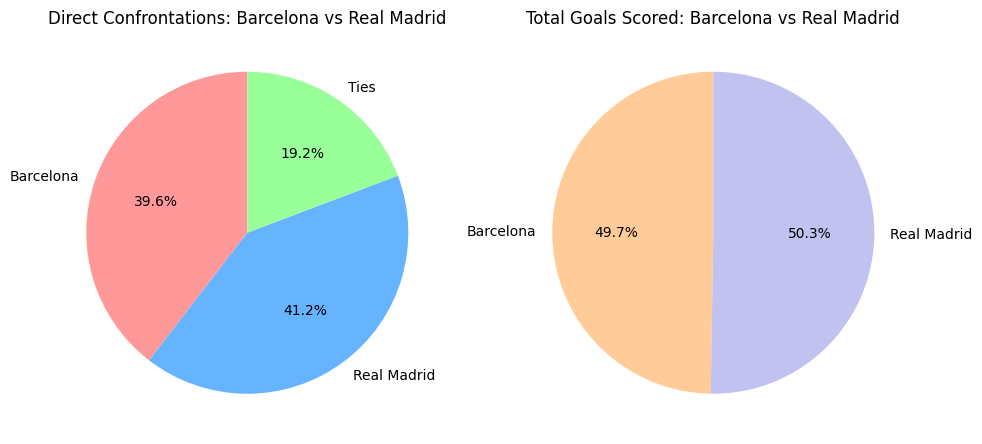

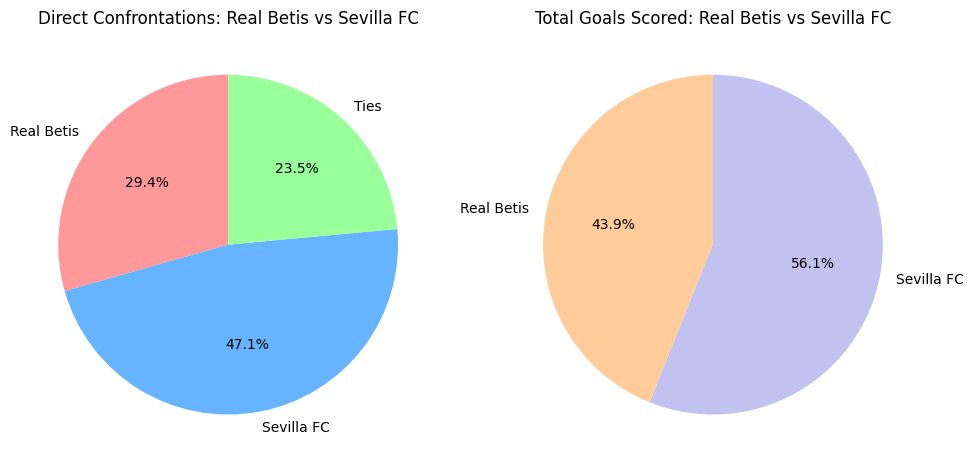

In [31]:
df['home_win'] = df['result'].apply(lambda x: 1 if x == 'Home Win' else 0)
df['away_win'] = df['result'].apply(lambda x: 1 if x == 'Away Win' else 0)
df['tie'] = df['result'].apply(lambda x: 1 if x == 'Draw' else 0)

def plot_direct_confrontations_stats(team1, team2):

    matches = df[((df['home_team'] == team1) & (df['away_team'] == team2)) |
                      ((df['home_team'] == team2) & (df['away_team'] == team1))]

    wins_team1 = matches.apply(lambda row: row['home_win'] if row['home_team'] == team1 else row['away_win'], axis=1).sum()
    wins_team2 = matches.apply(lambda row: row['home_win'] if row['home_team'] == team2 else row['away_win'], axis=1).sum()
    ties = matches['tie'].sum()

    goals_team1 = matches.apply(lambda row: row['home_score'] if row['home_team'] == team1 else row['away_score'], axis=1).sum()
    goals_team2 = matches.apply(lambda row: row['away_score'] if row['home_team'] == team1 else row['home_score'], axis=1).sum()

    wins_data = [wins_team1, wins_team2, ties]
    goals_data = [goals_team1, goals_team2]

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))

    ax[0].pie(wins_data, labels=[team1, team2, 'Ties'], autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
    ax[0].set_title(f'Direct Confrontations: {team1} vs {team2}')

    ax[1].pie(goals_data, labels=[team1, team2], autopct='%1.1f%%', startangle=90, colors=['#ffcc99', '#c2c2f0'])
    ax[1].set_title(f'Total Goals Scored: {team1} vs {team2}')

    plt.tight_layout()
    plt.show()

    return

# Plot confrontations Barcelona against Real Madrid and Real Betis against Sevilla FC
plot_direct_confrontations_stats("Barcelona", "Real Madrid")
plot_direct_confrontations_stats("Real Betis", "Sevilla FC")

*6. Between 1979 and 1980, Real Sociedad managed to chain a total of 38 games
without losing. That was, by far, the longest undefeated streak in their history. Which teams have had the longest undefeated streaks? Show the
longest undefeated streaks in a horizontal bar plot, indicating in each bar
the team name and the dates it held that streak, for instance, Real Sociedad
22/04/1979 - 04/05/1980.*

In order to compute the streaks of each team, we create a function that takes the result of each team and orders it chronologically. Then we sum the consecutive matches without a defeat and find the longest undefeated streaks.

In [32]:
def compute_streaks(df):

    df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
    df = df.loc[df['score'].notna()].copy()

    df['home_result'] = df.apply(lambda row: 'Defeat' if row['home_score'] < row['away_score']
                                 else 'Not Defeat', axis=1)
    df['away_result'] = df.apply(lambda row: 'Defeat' if row['away_score'] < row['home_score']
                                 else 'Not Defeat', axis=1)

    home_df = df[['date', 'home_team', 'home_result']].rename(columns={'home_team': 'team', 'home_result': 'result'})
    away_df = df[['date', 'away_team', 'away_result']].rename(columns={'away_team': 'team', 'away_result': 'result'})
    combined_df = pd.concat([home_df, away_df])

    combined_df.sort_values(['team', 'date'], inplace=True)

    combined_df['is_defeat'] = combined_df['result'] == 'Defeat'

    combined_df['streak_block'] = combined_df.groupby('team')['is_defeat'].cumsum()
    combined_df['date_before'] = combined_df.groupby(['team', 'streak_block'])['date'].shift(1)

    streaks_df = combined_df[combined_df['result'] == 'Not Defeat']

    streaks_summary = streaks_df.groupby(['team', 'streak_block']).agg(
        start_date=('date_before', 'min'),
        end_date=('date', 'max'),
        streak_length=('streak_block', 'count')
    ).reset_index()

    streaks_summary = streaks_summary.sort_values(by='streak_length', ascending=False)

    return streaks_summary[['team', 'start_date', 'end_date', 'streak_length']]

# Obtain the longest streaks using the function
longest_streaks = compute_streaks(df)


Then, we make the horizontal bar plot with the streaks and the inital and final dates of this.

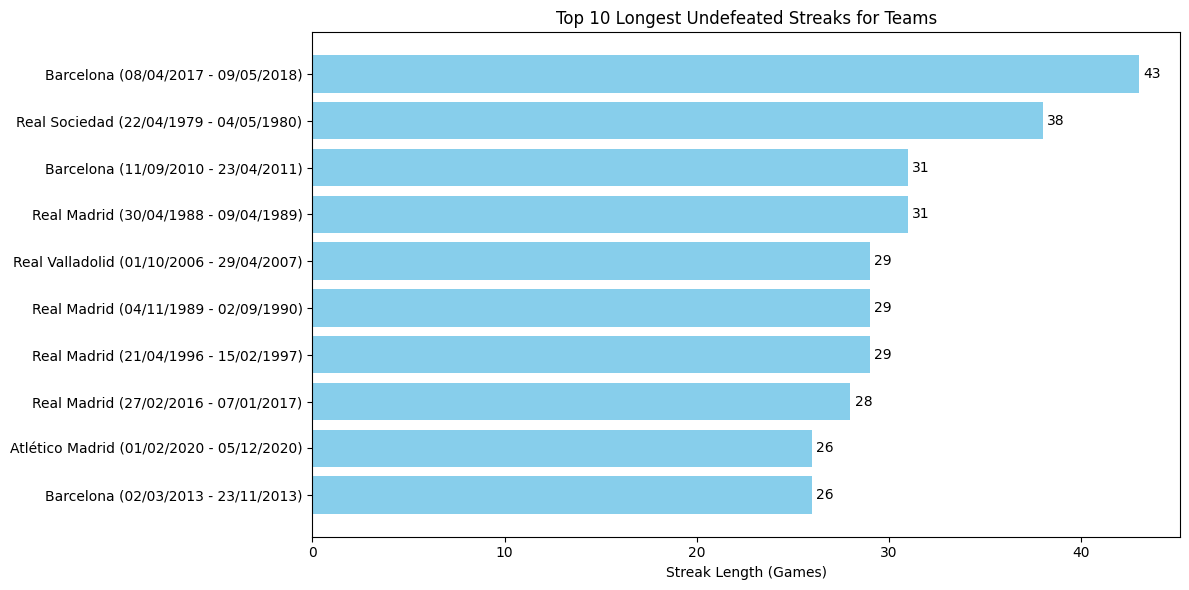

In [33]:
top_10_streaks = longest_streaks.head(10).copy()

# Plot
plt.figure(figsize=(12, 6))

top_10_streaks['Team_and_Dates'] = top_10_streaks.apply(
    lambda row: f"{row['team']} ({row['start_date'].strftime('%d/%m/%Y')} - {row['end_date'].strftime('%d/%m/%Y')})", axis=1)

top_10_streaks = top_10_streaks.iloc[::-1]

bars = plt.barh(top_10_streaks['Team_and_Dates'], top_10_streaks['streak_length'], color='skyblue')
plt.bar_label(bars, padding=3, fontsize=10)

plt.xlabel('Streak Length (Games)')
plt.title('Top 10 Longest Undefeated Streaks for Teams')

plt.tight_layout()
plt.show()


*7. Create a table with the final standings of each season (and division), that
is, a table that contains all the teams ordered (in descending order) by the
number of points they got during that season, and some other aggregate
statistics. The table must contain the following columns: season, division,
ranking, team, GF (total goals scored), GA (total goals conceded), GD (goals
difference), W (total wins), L (total loses), T (total ties), Pts (points). Remember that, in football, you earn 3 points per victory, and 1 point per tie (none
for loses). In case two teams have same number of points, order by GD (descending), and then by GF (also descending). Order the table so that standings of one season come before standings of previous one, and standings of
1st division come before standings of 2nd division.*

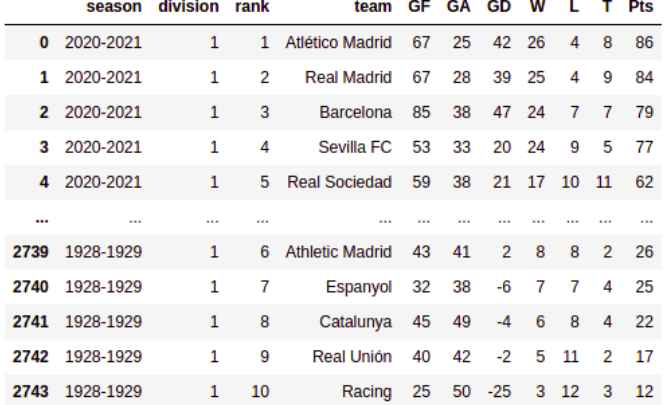

*Figure 2: Example of how standings table should look like.*


*Save the final table in Excel with the name SeasonStandings.xlsx in the
reports/ folder.*

We create a new dataframe where we store the stats of each team for each matchday. Then, we sum these stats for each season and compute some others, like the points earned. Then we sort them using the criteria specified before, and compute the rank of each team.

In [34]:
final_standings = pd.DataFrame()

home_stats = df.groupby(['season', 'division', 'home_team']).agg(
    GF=('home_score', 'sum'),
    GA=('away_score', 'sum'),
    W=('home_win', 'sum'),
    L=('away_win', 'sum'),
    T=('tie', 'sum')).reset_index()
home_stats.rename(columns={'home_team': 'team'}, inplace=True)

away_stats = df.groupby(['season', 'division', 'away_team']).agg(
    GF=('away_score', 'sum'),
    GA=('home_score', 'sum'),
    W=('away_win', 'sum'),
    L=('home_win', 'sum'),
    T=('tie', 'sum')).reset_index()
away_stats.rename(columns={'away_team': 'team'}, inplace=True)

final_standings = pd.concat([home_stats, away_stats])

final_standings = final_standings.groupby(['season', 'division', 'team']).agg(
    GF=('GF', 'sum'),
    GA=('GA', 'sum'),
    W=('W', 'sum'),
    L=('L', 'sum'),
    T=('T', 'sum')).reset_index()

final_standings['GD'] = final_standings['GF'] - final_standings['GA']
final_standings['M'] = final_standings['W'] + final_standings['L'] + final_standings['T']
final_standings['Pts'] = (final_standings['W'] * 3) + (final_standings['T'])

final_standings = final_standings.sort_values(by=['season', 'division',
                                                  'Pts', 'GD', 'GF'],
                                              ascending=[True, True,
                                                         False, False, False]).reset_index()

final_standings['rank'] = final_standings.groupby(['season',
                                                   'division'])['Pts'].rank(ascending=False,
                                                                            method='first')

final_standings = final_standings[['season', 'division', 'rank', 'team',
                                   'GF', 'GA', 'GD', 'M', 'W', 'L', 'T', 'Pts']]

final_standings = final_standings.sort_values(by=['season', 'division', 'rank'],
                                              ascending=[False, True, True]).reset_index(drop=True)

# Display the results to see if it worked
display(final_standings[final_standings['season'] == '2020-2021'].head(5))
display(final_standings[final_standings['season'] == '1928-1929'].tail(5))

# Save the final table
if not os.path.exists('reports'):
    os.makedirs('reports')
path = os.path.join('reports', 'SeasonStandings.xlsx')
final_standings.to_excel(path, index=False)

,season,division,rank,team,GF,GA,GD,M,W,L,T,Pts
42,2020-2021,1,1.0,Atlético Madrid,67,25,42,38,26,4,8,86
43,2020-2021,1,2.0,Real Madrid,67,28,39,38,25,4,9,84
44,2020-2021,1,3.0,Barcelona,85,38,47,38,24,7,7,79
45,2020-2021,1,4.0,Sevilla FC,53,33,20,38,24,9,5,77
46,2020-2021,1,5.0,Real Sociedad,59,38,21,38,17,10,11,62


,season,division,rank,team,GF,GA,GD,M,W,L,T,Pts
2781,1928-1929,1,6.0,Athletic Madrid,43,41,2,18,8,8,2,26
2782,1928-1929,1,7.0,Espanyol,32,38,-6,18,7,7,4,25
2783,1928-1929,1,8.0,Catalunya,45,49,-4,18,6,8,4,22
2784,1928-1929,1,9.0,Real Unión,40,42,-2,18,5,11,2,17
2785,1928-1929,1,10.0,Racing,25,50,-25,18,3,12,3,12


ModuleNotFoundError: No module named 'openpyxl'

*8. Villarreal is a team that has grown a lot in recent decades. Specially ever
since some billionaire guy bought it (Fernando Roig, from Mercadona).
Make a line plot showing the rank of Villarreal at the end of each season,
from the oldest ones (left) to the earliest ones (right). Consider rankings in
2nd division to be a continuation of the 1st one, that is, if there’s N teams in
1st division and Villarreal got r position in 2nd division, then it should be
placed in N + r. Draw in the same plot a line showing the cut between 1st
and 2nd division.*


*Write a function that, given n team names, plots the graph described above
of each one of them superposed. Function prototype should be like plot_-
ranking_evolution(team1, team2, ..., teamN) and return the plot object (note that function should not take one array-type argument, but n arguments). Use it to compare the evolution of all the teams that currently
play in 1st division.*


We create this function, that given a number of teams it plots their ranking evolution. We first compute the cutoff rank between 1st and 2nd division. Then we add the plot of each team superposed. Here, it is important to notice that the line of the ranking evolution disappears when the team gets relegated from 2nd division, since we don't exactly their ranking in the lower divisions.

In [ ]:
def plot_ranking_evolution(*teams):
    """
    Plots the ranking evolution of specified teams across seasons, with a cut line indicating the 1st/2nd division boundary.

    Parameters:
    *teams: str
        Names of the teams to include in the plot.

    Returns:
    plt: The plot object with all teams' ranking evolutions plotted.
    """
    # Read the excel created in the previous exercise to obtain the standings
    df = pd.read_excel('/content/reports/SeasonStandings.xlsx')
    df['season'] = df['season'].astype(str)
    seasons = sorted(df['season'].unique())

    cutoff_per_season = {}
    first_team_without_data = {}
    for season in seasons:
        first_div_teams = df[(df['season'] == season) & (df['division'] == 1)]
        # We add 0.5 in order to get the cutoff line between the last team of 1st division and the first one of 2nd
        cutoff_per_season[season] = first_div_teams['rank'].max() + 0.5
        second_div_teams = df[(df['season'] == season) & (df['division'] == 2)]
        first_team_without_data[season] = cutoff_per_season[season] + 0.5
        if pd.notnull(second_div_teams['rank'].max()):
            first_team_without_data[season] += second_div_teams['rank'].max()

    # Plot
    plt.figure(figsize=(16, 8))

    for team in teams:
        team_data = df[df['team'] == team].copy()
        team_data = team_data.set_index('season').reindex(seasons).reset_index()

        # Here we are considering the 2nd division as a continuation of the 1st one (we substract 0.5 because of the cutoff definition)
        team_data['adjusted_rank'] = team_data.apply(
            lambda row: row['rank'] + cutoff_per_season[row['season']] -0.5 if row['division'] == 2 
            else row['rank'] if pd.notnull(row['rank']) 
            else first_team_without_data[row['season']],
            axis=1
        )

        plt.plot(
            team_data['season'], team_data['adjusted_rank'], marker='', label=team
        )

    cutoff_values = [cutoff_per_season[season] if season in cutoff_per_season else None for season in seasons]
    total_teams_values = [first_team_without_data[season] if season in first_team_without_data else None for season in seasons]
    plt.plot(
        seasons, cutoff_values, marker='', label='Cut Line', linestyle='--', color='black'
    )
    plt.plot(
        seasons, total_teams_values, marker='', label='No rank data line', linestyle='dotted', color='black'
    )

    max_rank = int(df['rank'].max() + max(cutoff_per_season.values()))
    plt.yticks(range(1, max_rank + 1))
    plt.gca().invert_yaxis()
    plt.xticks(rotation=90)
    plt.xlabel('Season')
    plt.ylabel('Rank')
    plt.title('Rank Evolution of Villarreal Across Seasons')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xlim(seasons[0],seasons[-1])
    plt.tight_layout()

    return plt

# Use the previous function to plot the ranking evolution of Villareal
villarreal = ['Villarreal']
plt = plot_ranking_evolution(*villarreal)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/reports/SeasonStandings.xlsx'

*9. In football jargon, those teams that are permanently descending and ascending between 1st and 2nd division are called elevator teams. What are the
most elevator teams in LaLiga? Plot the history of the top 5 of them using the
function from exercise 8.*

For this exercise, we compute the division that each team was the previous season, and if we don't have the information of it, we remove it. Then we compute the times each team has been promoted or relegated and sort them by it. Finally we use the function of the previous exercise to plot the ranking evolution of those teams.

,team,division_change
0,Dep. La Coruña,20
1,Racing,17
2,Celta de Vigo,17
3,Rayo Vallecano,15
4,Real Murcia,14
5,Real Betis,14
6,Real Valladolid,14
7,CA Osasuna,13
8,RCD Mallorca,13
9,Hércules CF,13


['Dep. La Coruña', 'Racing', 'Celta de Vigo', 'Rayo Vallecano', 'Real Murcia']


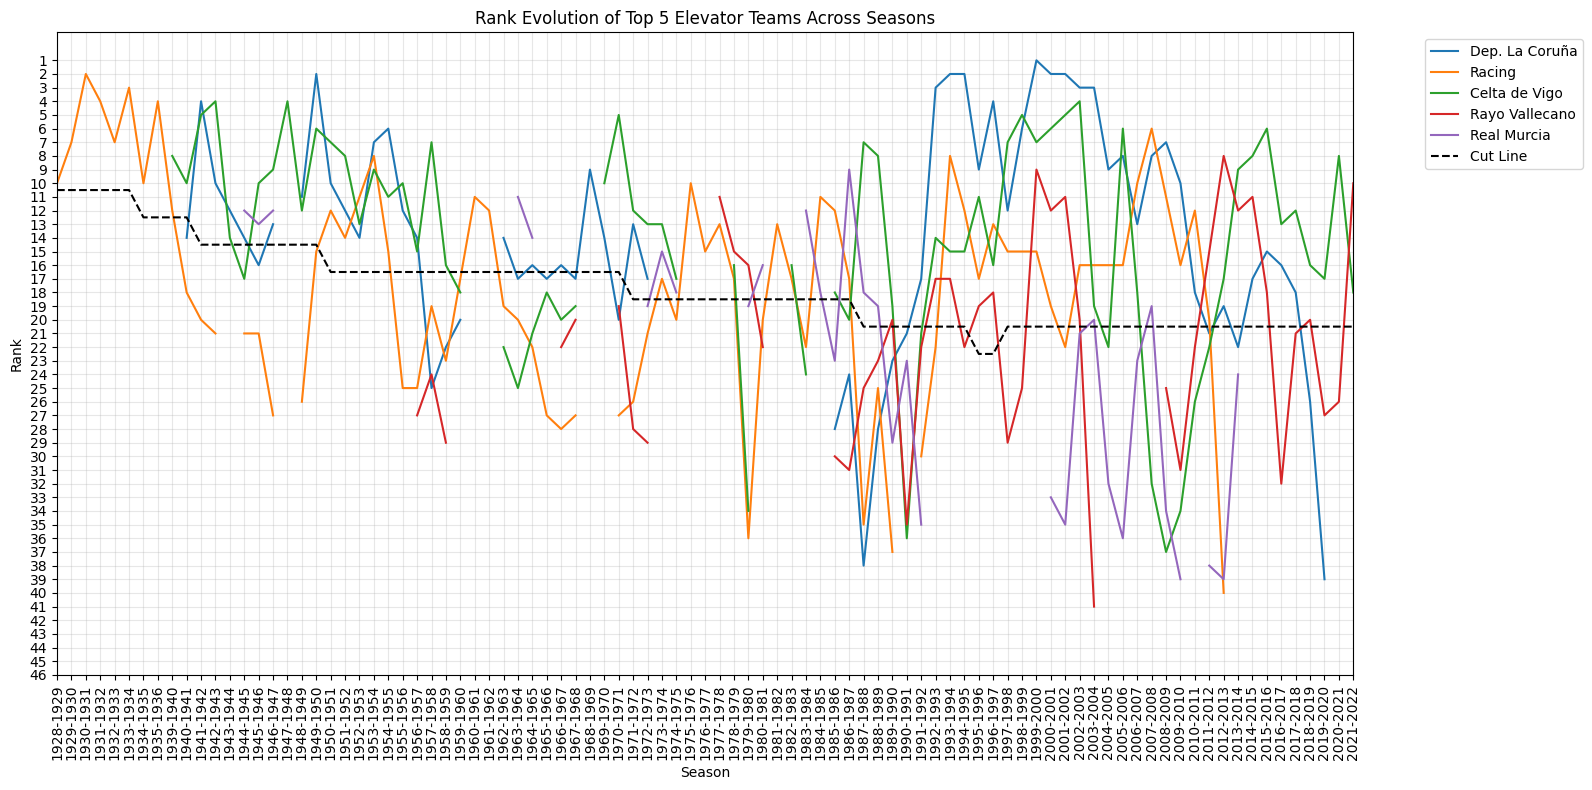

In [ ]:
team_seasonal_div = final_standings.loc[:,['season', 'team', 'division']]
team_seasonal_div = final_standings.sort_values(by=['team',
                                            'season']).reset_index(drop=True)
team_seasonal_div['prev_division'] = team_seasonal_div.groupby('team')['division'].shift(1)

# Remove the entries containing nan as they are generated because we don't have info from the previous season
team_seasonal_div= team_seasonal_div.dropna().reset_index(drop=True)

team_seasonal_div['division_change'] = team_seasonal_div['division'] != team_seasonal_div['prev_division']
teams_elev = team_seasonal_div.groupby('team')['division_change'].sum().reset_index()
teams_elev = teams_elev.sort_values(by='division_change', ascending=False).reset_index(drop=True)
display(teams_elev.head(10))

top_5_elev = teams_elev['team'].head(5).tolist()
print(top_5_elev)

# Use the plot function from Q8 to plot the top 5 elevator teams
fig = plot_ranking_evolution(*top_5_elev)
plt.title('Rank Evolution of Top 5 Elevator Teams Across Seasons')
plt.show()

*10. Create a table that is the same as the one in exercise 7, but not only with
the season final standings, but the standings at the end of each matchday.
Columns are the same, including matchday that tells about which matchday from the season these standings are from. Would you be able to add a
new column last_5 with the result of last 5 matches? This column should
contain a list like ["W", "L", "W", "T", "T"]. In this list, the first item is
the immediate previous match, the second one is the match before this one,
and so on. If there are no 5 previous matches (because matchday < 6, for
instance) then just make the list shorter.*

*Save the final table in Excel with the name MatchdayStandings.xlsx in the
reports/ folder.*

In [ ]:
df['home_GF'] = df["home_score"]
df['home_GA'] = df['away_score']
df['away_GF'] = df['away_score']
df['away_GA'] = df['home_score']
df['home_W'] = (df['result'] == 'Home Win').astype(int)
df['home_L'] = (df['result'] == 'Away Win').astype(int)
df['home_T'] = (df['result'] == 'Draw').astype(int)
df['away_W'] = (df['result'] == 'Away Win').astype(int)
df['away_L'] = (df['result'] == 'Home Win').astype(int)
df['away_T'] = (df['result'] == 'Draw').astype(int)


home_df = df[['season', 'division', 'matchday', 'home_team', 'home_GF', 'home_GA', 'home_W', 'home_L', 'home_T']]
home_df.columns = ['season', 'division', 'matchday', 'team', 'GF', 'GA', 'W', 'L', 'T']
away_df = df[['season', 'division', 'matchday', 'away_team', 'away_GF', 'away_GA', 'away_W', 'away_L', 'away_T']]
away_df.columns = ['season', 'division', 'matchday', 'team', 'GF', 'GA', 'W', 'L', 'T']
team_results = pd.concat([home_df, away_df])

matchday_standings = team_results.sort_values(['season', 'division', 'team', 'matchday'])
matchday_standings[['GF', 'GA', 'W', 'L', 'T']] = matchday_standings.groupby(['season', 'division', 'team'])[['GF', 'GA', 'W', 'L', 'T']].cumsum()

matchday_standings['GD'] = matchday_standings['GF'] - matchday_standings['GA']
matchday_standings['M'] = matchday_standings['W'] + matchday_standings['L'] + matchday_standings['T']
matchday_standings['Pts'] = matchday_standings['W'] * 3 + matchday_standings['T']

team_results['result'] = team_results.apply(lambda row: 'W' if row['W'] == 1 else 'L' if row['L'] == 1 else 'T', axis=1)
team_results.sort_values(['season', 'division', 'team', 'matchday'],inplace = True)

last_results = team_results.groupby(['season', 'division', 'team'])['result'].apply(lambda x: np.array([np.array(rolling_list) for rolling_list in x.rolling(5)],dtype=object))
matchday_standings["last_5"] = np.concatenate(last_results.values).reshape(-1)

matchday_standings = matchday_standings.sort_values(by=['season','division', 'matchday',
                                                  'Pts', 'GD', 'GF'],
                                              ascending=[True, True,True,
                                                         False, False, False])


matchday_standings.insert(3,'rank',matchday_standings.groupby(['season','division',
                                                   'matchday'])['Pts'].rank(ascending=False,
                                                                            method='first'))

matchday_standings = matchday_standings[['season', 'division', 'matchday', 'rank', 'team',
                                   'GF', 'GA', 'GD', 'M', 'W', 'L', 'T', 'Pts', 'last_5']]

display(matchday_standings[matchday_standings['season'] == '2020-2021'].head(5))
display(matchday_standings[matchday_standings['season'] == '1928-1929'].tail(5))



if not os.path.exists('reports'):
    os.makedirs('reports')
path = os.path.join('reports', 'MatchdayStandings.xlsx')
matchday_standings.to_excel(path, index=False)

,season,division,matchday,rank,team,GF,GA,GD,M,W,L,T,Pts,last_5
25447,2020-2021,1,1,1.0,Barcelona,3,0,3,1,1,0,0,3,[W]
25444,2020-2021,1,1,2.0,Valencia,4,2,2,1,1,0,0,3,[W]
25445,2020-2021,1,1,3.0,Atlético Madrid,2,0,2,1,1,0,0,3,[W]
25440,2020-2021,1,1,4.0,CA Osasuna,2,0,2,1,1,0,0,3,[W]
25439,2020-2021,1,1,5.0,Granada CF,2,0,2,1,1,0,0,3,[W]


,season,division,matchday,rank,team,GF,GA,GD,M,W,L,T,Pts,last_5
87,1928-1929,1,18,6.0,Athletic Madrid,43,41,2,18,8,8,2,26,"[L, W, W, T, W]"
87,1928-1929,1,18,7.0,Espanyol,32,38,-6,18,7,7,4,25,"[T, L, L, T, L]"
85,1928-1929,1,18,8.0,Catalunya,45,49,-4,18,6,8,4,22,"[T, T, L, W, L]"
89,1928-1929,1,18,9.0,Real Unión,40,42,-2,18,5,11,2,17,"[W, L, L, L, L]"
88,1928-1929,1,18,10.0,Racing,25,50,-25,18,3,12,3,12,"[T, L, W, L, W]"
